In [1]:
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
from specim.specfuncs import spec1d
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
data =  spec1d.Spec1d('../HE0435_spec.fits', informat='mwa')
lamda_galaxy = data['wav']
spectra_galaxy = data['flux']
variance_spectra_galaxy = data['var']
lamda_galaxy_range =  [np.min(lamda_galaxy), np.max(lamda_galaxy)]
#print(data)



Reading spectrum from ../HE0435_spec.fits
Expected file format: mwa
 Spectrum Start:  5570.31
 Spectrum End:     7899.01
 Dispersion (1st pixel):   0.58
 Dispersion (average):      0.58



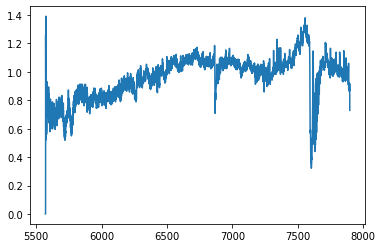

In [3]:
median_spectra_gal = np.median(data['flux'])       # median of the spectra_galaxy
spectra_galaxy_normalized = spectra_galaxy / median_spectra_gal
plt.plot(lamda_galaxy, spectra_galaxy_normalized)

In [4]:
c = 299792.458                                 # speed of light in km/s
frac_lamda = lamda_galaxy[1]/ lamda_galaxy[0]  # Constant lambda fraction per pixel
velocity_scale =  np.log(frac_lamda)*c         # velocity scale in km/s per pixel
print('Velocity_scale=', velocity_scale)

Velocity_scale= 31.213817586671198


In [5]:
spectra_galaxy_rebinned, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, spectra_galaxy_normalized, 
                                                         velscale=velocity_scale)

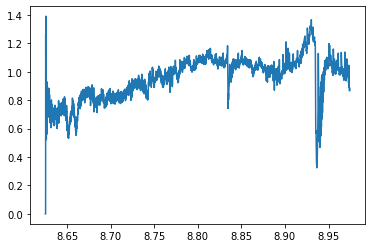

In [6]:
plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned)

In [7]:
template_data = spec1d.Spec1d('../TEXT/101484.txt')
lamda_template = template_data['wav']                      # wavelength in angstrom
spectra_template = template_data['flux']                     # spectra
lamda_template_range = [np.min(lamda_template), np.max(lamda_template)]
#print(lamda_template_range)


Reading spectrum from ../TEXT/101484.txt
Expected file format: text
 Spectrum Start:  3465.00
 Spectrum End:     9469.00
 Dispersion (1st pixel):   0.40
 Dispersion (average):      0.40



In [8]:
spectra_template_rebinned, log_lamda_template, vscale = util.log_rebin(lamda_template_range, spectra_template,
                                                                  velscale=velocity_scale)

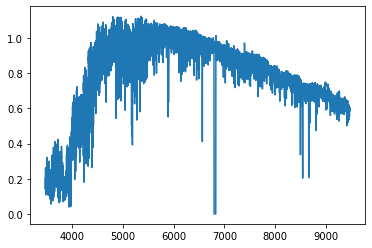

In [9]:
plt.plot(lamda_template, spectra_template)

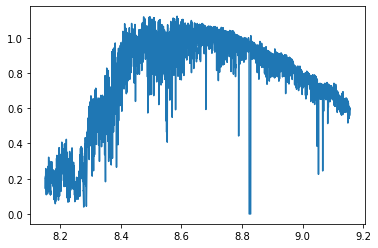

In [10]:
plt.plot(log_lamda_template, spectra_template_rebinned)

In [12]:
fwhm_template_spectra = 1.0

def gen_sigma_diff(sig_ins):
    
    sigma_instrument = sig_ins                           #sigma of the instrumental LSF
    fwhm_galaxy = 2.355 * sigma_instrument           # FWHM of every pixel in Angstrom
    fwhm_galaxy_spectra  = np.full(len(lamda_galaxy), fwhm_galaxy)
    
    fwhm_interp_gal_spec = np.interp(lamda_template, lamda_galaxy, fwhm_galaxy_spectra)  #interpolated fwhm
    fwhm_diff = np.sqrt(fwhm_interp_gal_spec**2 - fwhm_template_spectra**2)
    sigma_diff = fwhm_diff / 2.355
    
    return sigma_diff

In [13]:
sigma_instrument = 0.95
sigma_diff = gen_sigma_diff(sigma_instrument)

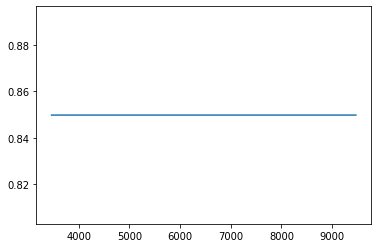

In [16]:
plt.plot(lamda_template, sigma_diff)

In [17]:
dv = c*np.log(lamda_template[0]/lamda_galaxy[0]) 

In [18]:
z = 0.454              # redshift from input spectra
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.0]  
#print(vel)

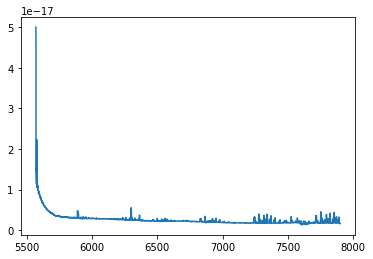

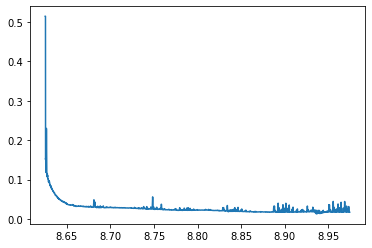

In [19]:
sigma_galaxy_spectra = np.sqrt(variance_spectra_galaxy) 
noise = sigma_galaxy_spectra / median_spectra_gal

noise_rebinned, log_lamda_noise, velo_scale = util.log_rebin(lamda_galaxy_range,
                                                             noise,
                                                           velscale=velocity_scale)
plt.plot(lamda_galaxy, sigma_galaxy_spectra)
plt.figure()
#print(velo_scale)
#print(np.size(noise_new))
plt.plot(log_lamda_noise, noise_rebinned)

In [20]:
def masking(length, pixel_range, log_lamda_gal):
    '''
    This function generate and returns a boolean array with value 'False'
    in the pixel locations which should be excluded from the fit.
    
    Parameters
    ---------------
    length: int
        The length of the logarithmically rebinned galaxy spectra. The 
        boolean array would be of the same size.
        
    pixel_range: list
        A list of tuples where each tuple contains start and end of the
        pixel range needs to be excluded.
        
    log_lamda_gal: array
        This array contains the values of the logarithmically 
        rebinned wavelengths.
    
    Returns
    -------------
    mask : boolean array
        Boolean array with with value 'False' in the pixel locations 
        which should be excluded from the fit.
        
    '''
    
    mask = np.zeros(length, dtype=bool)
    for i,p in enumerate(pixel_range):
        mask |= (log_lamda_gal>=p[0]) & (log_lamda_gal <= p[1])
    return (~mask)

In [21]:
# Extended masking

pixel_range_new = [(8.6252, 8.62938), (8.8268, 8.84623), (8.91133, 8.9749)]

In [22]:
mask = masking(spectra_galaxy_rebinned.size, pixel_range_new, log_lamda_galaxy)

In [54]:
def gen_rebinned_templates(temp_num, sigma_diff):
    
    indo_us_library = glob.glob('../TEXT/*')[:temp_num]
    templates = np.empty((spectra_template_rebinned.size, len(indo_us_library)))
    
    filename = []

    for j, file_name in enumerate(indo_us_library):
        
        filename.append(file_name)
        
        template_data = spec1d.Spec1d(file_name, verbose=False)
        template_spectra = template_data['flux']

        # perform convolution with variable sigma_diff    
        convolved_temp_spectra= util.gaussian_filter1d(template_spectra, sigma_diff)  

        template_spectra_rebinned = util.log_rebin(lamda_template_range, convolved_temp_spectra, 
                                          velscale=velocity_scale)[0]
        templates[:, j] = template_spectra_rebinned / np.median(template_spectra_rebinned) # Normalizes 
                                                                                           # templates
    return templates, filename

### Here we are varying template numbers and recording which template files have been used to fit. ppxf provides an array of wieghts assigned to each of the templates during the fit procedure. Finding out the indexes of the nonzero elements from the weight array and matching them with the array containing all the template file names we can find out which templates have been used.

In [57]:
template_number = [200, 300, 400, 500, 600, 700, 800]
#tamplates,  = gen_rebinned_templates(200, sigma_diff)

template number: 200 

200
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112216       224     0.008    -0.047
chi2/DOF: 0.9408
method = capfit; Jac calls: 2; Func calls: 12; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  14 / 200
../TEXT/215373.txt
../TEXT/209409.txt
../TEXT/180890.txt
../TEXT/18474.txt
../TEXT/207089.txt
../TEXT/107752.txt
../TEXT/G_107-27.txt
../TEXT/167768.txt
../TEXT/205512.txt
../TEXT/1967.txt
../TEXT/81797.txt
../TEXT/G_196-48.txt
../TEXT/BD+37_448.txt
../TEXT/161817.txt
template number: 300 

300
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112217       224     0.009    -0.048
chi2/DOF: 0.935
method = capfit; Jac calls: 2; Func calls: 12; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  13 / 300
../TEXT/215373.txt
../TEXT/180890.txt
../TEXT/18474.txt
../TEXT/207089.txt
../TEXT/107752.txt
../TEXT/G_107-27.txt
../TEXT/205512.txt
../TEXT/1967.txt
../TEXT/81797.txt
../TEXT/161817.txt
../TEXT/187929.txt
.

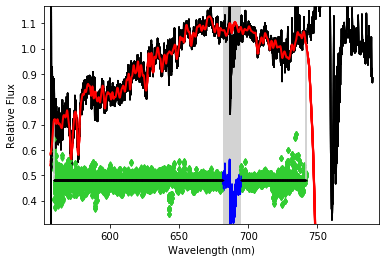

In [58]:
total_used_template_list = []     # A list of lists containing template file names being used 

for i, p in enumerate(template_number):
    
    templates, file_name = gen_rebinned_templates(p, sigma_diff)
    
    print('template number: %d \n' %p)
    print(len(file_name))
    
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
         plot=True, vsyst=dv, degree=12, mask=mask, lam=np.exp(log_lamda_galaxy))
    
    
    non_zero_temp_index = []
    for j, weight in enumerate(pp.weights):
    
        if weight != 0:
            non_zero_temp_index.append(j)
    
    used_template = []
    for k, index in enumerate(non_zero_temp_index):
    
        print(file_name[index])
        used_template.append(file_name[index])
    
    total_used_template_list.append(used_template)
    

### Here we have  a count of how many times each template from the list of total used templates have been used while we varied provived template numbers from 200 to 800.

In [60]:
from collections import Counter

In [62]:
cnt = Counter()
for i, p in enumerate(total_used_template_list):
    
    for j, m in enumerate(p):
        
        cnt[m] += 1

In [64]:
cnt

Counter({'../TEXT/215373.txt': 3,
         '../TEXT/209409.txt': 1,
         '../TEXT/180890.txt': 2,
         '../TEXT/18474.txt': 7,
         '../TEXT/207089.txt': 7,
         '../TEXT/107752.txt': 7,
         '../TEXT/G_107-27.txt': 7,
         '../TEXT/167768.txt': 1,
         '../TEXT/205512.txt': 6,
         '../TEXT/1967.txt': 7,
         '../TEXT/81797.txt': 2,
         '../TEXT/G_196-48.txt': 1,
         '../TEXT/BD+37_448.txt': 1,
         '../TEXT/161817.txt': 2,
         '../TEXT/187929.txt': 6,
         '../TEXT/223075.txt': 6,
         '../TEXT/9856.txt': 1,
         '../TEXT/G_180-35.txt': 4,
         '../TEXT/202573.txt': 1,
         '../TEXT/142980.txt': 5,
         '../TEXT/92055.txt': 2,
         '../TEXT/BD+45_1668.txt': 5,
         '../TEXT/29645.txt': 1,
         '../TEXT/163917.txt': 2,
         '../TEXT/102634.txt': 2,
         '../TEXT/185657.txt': 4,
         '../TEXT/178266.txt': 1,
         '../TEXT/102574.txt': 3,
         '../TEXT/137510.txt': 1,
         

### Next we need to check whether these template files we have extracted given the weight array are trully the used templates in the fit. To do that here I am providing only those template files to the ppxf and check whther the results match. For example previously we provided 200 templates to the ppxf to fit. However now we are just providing only those 14 templates which we believe been used during the fit and match both the results from both case. We found that the results match for all the different template number scenario from 200 to 800.

Provided template number : 14
we are predicting used template number would be : 14 

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112216       224     0.008    -0.047
chi2/DOF: 0.9408
method = capfit; Jac calls: 2; Func calls: 12; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  14 / 14
Templates weights:
   0.00247   0.00156     0.066    0.0568    0.0273    0.0416   0.00571    0.0257   0.00265   0.00574    0.0621    0.0424     0.112   0.00476
Provided template number : 13
we are predicting used template number would be : 13 

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112217       224     0.009    -0.048
chi2/DOF: 0.935
method = capfit; Jac calls: 2; Func calls: 12; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  13 / 13
Templates weights:
    0.0833    0.0766    0.0541    0.0265    0.0919   0.00882   0.00292   0.00209     0.017   0.00503    0.0189    0.0167    0.0477
Provided template number : 15
we are predicting used 

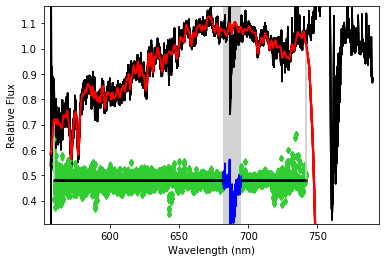

In [67]:
for i, p in enumerate(total_used_template_list):
    
    used_templates_binned = np.empty((spectra_template_rebinned.size, len(p)))
    
    print('Provided template number : %d' %len(p))
    print('we are predicting used template number would be : %d \n' %len(p))
    
    for l, f in enumerate(p):
        
        #filename.append(file_name)
        
        template_data = spec1d.Spec1d(f, verbose=False)
        template_spectra = template_data['flux']

        # perform convolution with variable sigma_diff    
        convolved_temp_spectra= util.gaussian_filter1d(template_spectra, sigma_diff)  

        template_spectra_rebinned = util.log_rebin(lamda_template_range, convolved_temp_spectra, 
                                          velscale=velocity_scale)[0]
        used_templates_binned[:, l] = template_spectra_rebinned / np.median(template_spectra_rebinned)
    
    pp = ppxf(used_templates_binned, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
                 plot=True, vsyst=dv, degree=12, mask=mask, lam=np.exp(log_lamda_galaxy))
    